# MVA - Homework 1 - Reinforcement Learning (2021/2022)

**Name:** SIMON Hugo

## Instructions

* The deadline is **November 12 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/ktmvsc4knke4ia?cid=6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [2]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [3]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [4]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [5]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 


In [6]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

Denote by a tilde quantities associated to the affine transformed reward $\tilde r = \alpha r + \beta$

Then $\tilde V^\pi = ( I - \gamma P^\pi)^{-1} \tilde r^\pi = ( I - \gamma P^\pi)^{-1} (\alpha r^\pi + \beta) = \alpha V^\pi + \beta( I - \gamma P^\pi)^{-1}$

This quantity is not necessarily minimized by $\pi^*$, i.e. the optimal policy is not preserved in general.

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

Denote $\pi_Q(s) = \arg\!\max_a Q(s,a)$ and $Q(\pi) : s \mapsto Q(s,\pi(s))$ 

\begin{align}
||V^*-V^{\pi_Q}||_\infty &=||Q^*(\pi^*)-Q^{\pi_Q}(\pi_Q)||_\infty \\
&\leq ||Q^*(\pi^*)-Q^*(\pi_Q)||_\infty + ||Q^*(\pi_Q)-Q^{\pi_Q}(\pi_Q)||_\infty \\
&\leq ||Q^*(\pi^*)-Q(\pi_Q)||_\infty + ||Q(\pi_Q)-Q^*(\pi_Q)||_\infty + ||\mathcal T^{\pi_Q}V^* - \mathcal T^{\pi_Q}V^{\pi_Q}||_\infty \quad\quad (\text {using that }Q^{\pi'}(\pi)=\mathcal T^\pi V^{\pi '})\\
&\leq 2||Q^*-Q||_\infty + \gamma ||V^*-V^{\pi_Q}||_\infty \quad\quad (\text {using that } Q^*(\pi^*) - Q(\pi_Q) = \max_a Q^*(a)-\max_a Q(a) \leq \max_a Q^*(a)-Q(a) )\\
&\leq \frac{2}{1-\gamma}||Q^*-Q||_\infty
\end{align}

Therefore
$$||V^*-V^{\pi_{Q^*}}||_\infty \leq  \frac{2}{1-\gamma}||Q^*-Q^*||_\infty = 0 \implies V^{\pi_{Q^*}}  = V^* $$ 
i.e. $\pi_{Q^*}$ is optimal.

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**
* Each iteration of Value iteration has low time complexity ($O(SA)$ below) but it converges only asymptotically.
* Policy iteration converges in finite number of iterations but each iteration might be expensive ($O(S^3+S^2A)$ below).


In [7]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    Ns = policy.shape[0]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    Ppi = np.zeros((Ns,Ns))
    Rpi = np.zeros(Ns)

    for s in range(Ns):
      Rpi[s] = R[s, policy[s]]
      for snext in range(Ns):
        Ppi[s,snext] = P[s,policy[s],snext]

    value_function = np.linalg.solve(np.eye(Ns) - gamma * Ppi, Rpi)
    # ====================================================
    return value_function

In [10]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=np.int)
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    Vnext = policy_evaluation(P, R, policy, gamma)

    while (Vnext - V).max() > tol:
      V = Vnext
      policy = (R + gamma * P @ Vnext).argmax(axis=1)
      Vnext = policy_evaluation(P, R, policy, gamma)

    V = Vnext
    # ====================================================
    return policy, V

In [11]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    Q = R + gamma * P @ (Qfs[-1].max(axis=1))

    while (Q - Qfs[-1]).max() > tol:
      Qfs += [Q]
      Q = R + gamma * P @ (Qfs[-1].max(axis=1))
    
    Qfs += [Q]
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


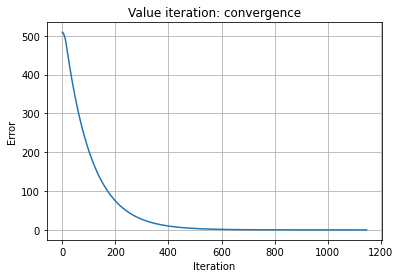

In [12]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma)
# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
    "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
    "Since the policies are equal, even the value function should be"

plt.grid(), plt.show();

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

Uniform sampling method is in this case often better because it allows a representative description of the system. Whereas terminal states are difficultly reached by random action policy method, and because reward is really sparse in this problem, this leads to policy iteration or value iteration to not increase at all.

In [71]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)

# ====================================================
# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

def estimate_MDP(dataset):
  states, actions, rewards, next_states = dataset

  A_hat = np.max(actions)+1
  S_hat = np.concatenate((states, next_states)).max()+1

  Nsas = np.zeros((S_hat, A_hat, S_hat))
  Nsa = np.zeros((S_hat, A_hat))
  R_hat = np.zeros((S_hat, A_hat))
  P_hat = np.zeros((S_hat, A_hat, S_hat))

  for state, action, reward, next_state in zip(states, actions, rewards, next_states):
    Nsa[state, action] += 1
    Nsas[state, action, next_state] += 1
    R_hat[state, action] += reward

  np.divide(Nsas.T, Nsa.T, out=P_hat.T, where=(Nsa.T!=0))
  np.divide(R_hat, Nsa, out=R_hat, where=(Nsa!=0))

  return P_hat, R_hat

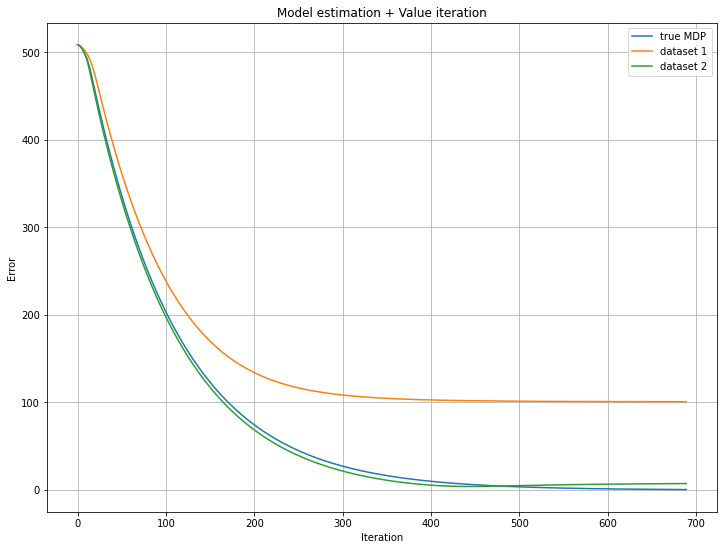

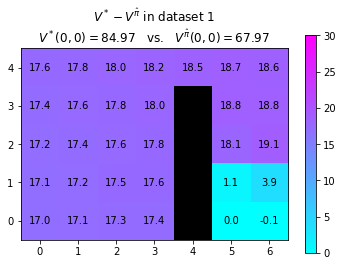

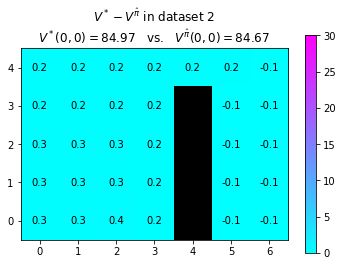

In [72]:
gamma = 0.99
# run value iteration to obtain Q-values
Q, pi, Q_list = value_iteration(env.P, env.R, gamma=gamma)
true_V = Q_list[-1].max(axis=1)

# show the error between the computed V-functions on true model and the true V-function
norms = [ np.linalg.norm(Q.max(axis=1) - true_V) for Q in Q_list]
fig1, ax1 = plt.subplots(figsize=(12,9))
plt.plot(norms, label='true MDP')

dataset_list = [['dataset 1', dataset_1], ['dataset 2', dataset_2]]
for i in range(len(dataset_list)):
  # estimate MDP with dataset
  P_hat, R_hat = estimate_MDP(dataset_list[i][1])

  # run value iteration to obtain Q-values on estimated MDP
  Q_hat, pi_hat, Q_hat_list = value_iteration(P_hat, R_hat, gamma=gamma)

  # show the error between the computed V-functions on estimated model and the true V-function
  hat_norms = [ np.linalg.norm(Q.max(axis=1) - true_V[:len(pi_hat)]) for Q in Q_hat_list]
  ax1.grid(True)
  ax1.plot(hat_norms, label=dataset_list[i][0])
  
  # compute the value function of the greedy policy using matrix inversion
  V_pi_hat = np.zeros_like(true_V)
  V_pi_hat[:len(pi_hat)] = policy_evaluation(env.P, env.R, pi_hat, gamma)

  # compute and plot heatmap of difference between performance of pi star and pi hat
  fig2, ax2 = plt.subplots(figsize=(6,4)) 
  xlim, ylim = np.array(env.index2coord[len(true_V)-1]) + 1
  heatmap_diff, heatmap_walls = np.zeros((xlim, ylim)), np.zeros((xlim, ylim))
  for j in range(len(true_V)):
    x,y = env.index2coord[j]
    heatmap_diff[x,y] = true_V[j] - V_pi_hat[j]
    text = ax2.text(y, x, round(heatmap_diff[x,y],1),ha="center", va="center", color="k")
  for wall in env.walls:
    heatmap_walls[wall] = 1
        
  plt.imshow(heatmap_diff, cmap='cool', interpolation='nearest', vmin=0, vmax=30)
  plt.colorbar()
  ax2.imshow(heatmap_walls, cmap='gray_r', alpha=heatmap_walls, interpolation='nearest')
  ax2.invert_yaxis(), ax2.set_title('$V^*-V^{\hat\pi}$ in '+dataset_list[i][0]+\
        '\n$V^*(0,0)=$'+f'{true_V[0]:.2f}   vs.   '+'$V^{\hat\pi}(0,0)=$'+f'{V_pi_hat[0]:.2f}')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Error')
ax1.set_title('Model estimation + Value iteration')
ax1.legend(), plt.show();


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) simulation lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**
Denote by a hat quantities and operators associated to the estimated MDP.  
Denote by $||\cdot ||_{a,b,c}$ the c-norm with respect to the third coordinate, b-norm w.r.t the second, a-norm w.r.t. the first, in this order. 

\begin{align}
||V^*-\hat V||_\infty &= ||\mathcal T V^* - \hat{\mathcal T} \hat V||_\infty\\
&\leq ||\mathcal T V^* - \hat{\mathcal T} V^*||_\infty + ||\hat{\mathcal T} V^* -  \hat{\mathcal T} \hat V||_\infty\\
&\leq ||\mathcal T V^* - \hat{\mathcal T} V^*||_\infty + \gamma||V^* - \hat V||_\infty\\
&\leq \frac 1 {1-\gamma} ||\mathcal T V^* - \hat{\mathcal T} V^*||_\infty\\
&\leq \frac 1 {1-\gamma}||r + \gamma P V^* - (\hat r + \gamma \hat P V^*)||_{\infty\times\infty}  \quad\quad (\text {using that } \max_a f(a)-\max_a g(a) \leq \max_a f(a)-g(a))\\
&\leq \frac 1 {1-\gamma}||r-\hat r||_{\infty\times\infty} + \frac \gamma {1-\gamma}||(P-\hat P)V^*||_{\infty\times\infty}\\
&\leq \frac 1 {1-\gamma}||r-\hat r||_{\infty\times\infty} + \frac \gamma {1-\gamma}||V^*||_\infty ||P-\hat P||_{\infty\times\infty\times1}\\
&\leq \frac 1 {1-\gamma}||r-\hat r||_{\infty\times\infty} + \frac \gamma {(1-\gamma)^2}||r||_{\infty\times\infty} ||P-\hat P||_{\infty\times\infty\times1} \quad\quad (\text {using that } ||V^*||_\infty \leq \frac 1 {1-\gamma}||r||_{\infty\times\infty})
\end{align}

But by Hoeffding inequality and the union bound, we have $1-\delta$ surely

* $ ||r-\hat r||_{\infty\times\infty} \leq \varepsilon ||r||_{\infty\times\infty}$

* $||P-\hat P||_{\infty\times\infty\times1} \leq \varepsilon S$

where $\varepsilon = \sqrt{\frac 1 {2N} \log(\frac {2SA} \delta})$

Noticing that $||r||_{\infty\times\infty}\leq 1$, which finally leads to
$$||V^*-\hat V||_\infty \leq \frac {(1 + \gamma(S-1))}{(1-\gamma)^2}\sqrt{\frac 1 {2N} \log(\frac {2SA} \delta}), \quad\quad 1-\delta \text{ surely}$$


## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

* **Combining modelling with Q-learning leads to Dyna-Q**  
We do classical Q-learning but after each true model sampling according to the behavioural policy, we update the model. This way, samples used to model the system are more relevant. Then by taking a batch of observed states and previously taken actions, we can sample from the updated model corresponding rewards and next states. We can then iteratively update Q several times before having to resample from the true system. 
* **Combining modelling with SARSA is pretty closed**  
We do classical SARSA, and after observing reward and next state, we update the model. Then by taking a batch of observed states and previously taken actions, we can sample from the updated model corresponding rewards and next states. We can then iteratively update Q several times, taking actions with respect to the current policy. 

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**
With linear function approximation, the problem is indeed convex.  
First order condition writes
\begin{equation}
\nabla_{\theta_a}\text{Loss} = \sum_{a_i=a} \phi(s_i)(\phi(s_i)^\top \theta_a - y_i) + \lambda \theta_a = 0 \\
\iff \theta_a = (\sum_{a_i=a} \phi(s_i)\phi(s_i)^\top + \lambda I)^{-1}\sum_{a_i=a} y_i\phi(s_i)
\end{equation}


## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

Trying to reduce approximation error
* using uniform sampling for a better represantativity.
* increasing number of sampling and feature dimensionnality.
* playing with $\lambda$ regularisation coefficient.
* testing different kernel, e.g. gaussian, laplacian, cauchy, sinc... Here, sinc kernel perform a bit better than gaussian kernel.

In [81]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env

class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    dist = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist[ii, jj] = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
    
    # sim_matrix = np.exp(-(dist / sigma) ** 2.0)
    sim_matrix = np.sinc( np.pi*(dist / sigma) )

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [74]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[ 0.07846466 -0.018586    0.04533672  0.11066411 -0.04435395 -0.13474441
  0.10390833 -0.05144767  0.03319072  0.01447388  0.10842529  0.02667739
  0.13425713 -0.13543481  0.09424551]
(15, 4)
[0. 0. 0. 0.]


In [82]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95, n_samples=10000):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  # dataset = get_random_policy_dataset(env, n_samples=n_samples)
  dataset = get_uniform_dataset(env, n_samples=n_samples)
  states, actions, rewards, next_states = np.array(dataset, dtype=int)

  theta = np.zeros((feat_map.dim, env.Na))
  phi = feat_map.map(states).T
  phi_prime = feat_map.map(next_states).T

  V_fqi_list = []

  for it in range(num_iterations):
    
    y = rewards + gamma*(phi_prime @ theta).max(axis=1)

    for action in range(env.Na):
  
      phi_a = phi[actions == action]
      cov_y_phi_a = y[actions == action] @ phi_a
      cov_phi_phi_a = phi_a.T @ phi_a

      theta[:,action] = np.linalg.solve( cov_phi_phi_a + lambd*np.eye(len(cov_y_phi_a)),  cov_y_phi_a)
    
    Q_fqi = feat_map.map(range(env.Ns)).T @ theta
    V_fqi_list.append( Q_fqi.max(axis=1) )
  return theta, np.array(V_fqi_list)

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=200, sigma=0.5)

# -------
# Run FQI
# -------
theta, V_fqi_list = linear_fqi(env, feat_map, num_iterations=100, lambd=0.1, gamma=0.95, n_samples=10000)

# Compute and run greedy policy
Q_fqi = feat_map.map(range(env.Ns)).T @ theta
V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

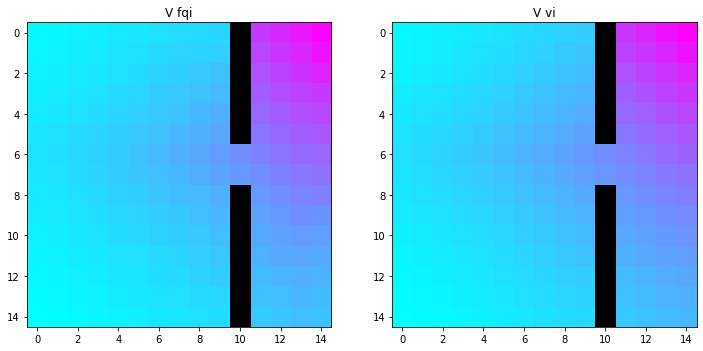

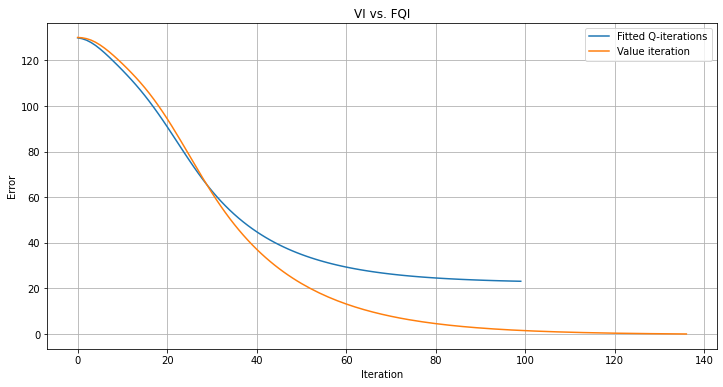

In [83]:
# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)
fig, axes = plt.subplots(1,2, figsize=(12,12))   
ax1, ax2 = axes
ax1.imshow(img)
ax1.set_title('V fqi')

Q_vi, pi_vi, Q_vi_list = value_iteration(env.P, env.R, gamma=0.95)
V_vi = Q_vi_list[-1].max(axis=1)
img = env.get_layout_img(V_vi)    
ax2.imshow(img)
ax2.set_title('V vi')

plt.figure(figsize=(12,6))
fqi_norms = [ np.linalg.norm(V - V_vi) for V in V_fqi_list]
vi_norms = [ np.linalg.norm(Q.max(axis=1) - V_vi) for Q in Q_vi_list]
plt.plot(fqi_norms, label="Fitted Q-iterations")
plt.plot(vi_norms, label="Value iteration")
plt.xlabel('Iteration'), plt.ylabel('Error')
plt.title('VI vs. FQI'), plt.legend(),
plt.grid(), plt.show();